# Differentiable Rendering

## camera pos estimation 
optimize camera pos given target depth  image(and shade normal image) and initial depth(and shade noraml image)

In [1]:
 ## mount google drive on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install pyrender
## install Redner library (differetiable renderring library)
!pip install --upgrade redner-gpu
!pip install kornia
!pip install pyquaternion

     |████████████████████████████████| 1.2 MB 12.0 MB/s 
     |████████████████████████████████| 640 kB 48.8 MB/s 
     |████████████████████████████████| 890 kB 44.2 MB/s 
     |████████████████████████████████| 2.2 MB 40.3 MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=30296b11da2beb1a1abd17340071683a14c2948c96f2accc2103f8c44619c374
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.5
    Uninstalling PyOpenGL-3.1.5:
      Successfully uninstalled PyOpenGL-3.1.5
     |████████████████████████████████| 31.8 MB 1.8 MB/s 
     |████████████████████████████████| 401 kB 12.1 MB/s 


In [6]:
%cd /content/drive/MyDrive/BigDataHub/Differentiable_Render

/content/drive/MyDrive/BigDataHub/Differentiable_Render


In [7]:
import pyredner
import torch
import redner
import matplotlib.pyplot as plt
import kornia as K
import numpy as np
import torchvision
from matplotlib.pyplot import figure
import numpy as np
import pyrender
import trimesh.transformations as transformations
%matplotlib inline
from IPython.display import display, clear_output
import time
import scipy.spatial.transform
import pandas as pd
from utils import *
from utils_redner_transform import *
from dict_utils import *
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_quat.html
from training_model_zoo import*
import os
import cv2
import torchvision.transforms as transforms
import sys
from  pyquaternion import Quaternion

# Camera pose opimization with network

In [8]:
# select a sweep from train_metadata.txt
# Get the source image infomaiton  sweep from a specific id 
def get_sweep_info(file_dir, seq_file, ex_id):
    
    df_st = pd.read_csv(file_dir + seq_file, header=None)
    df_st[21] = None
    df_st.loc[:,12:21] = df_st.loc[:,11:20].values
    df_st.loc[:,10:11] = df_st.loc[:,10].str.split(expand=True).values
    
    #get the sample
    sample_info = df_st.iloc[ex_id,:].to_numpy()
    #print("sample info :", sample_info)
    
    tg_img_name = sample_info[0]
    sweep_names = sample_info[1:11]
    #print(f"sweep name: {sweep_names}")

    return sample_info

In [9]:
# feed pair of image to network
def loss_from_network(tg_img, source_img):
  # orgnize the input format: 
  # target image: (batch_size, c, h, w), 
  tg_bgr: torch.Tensor = K.utils.image_to_tensor(tg_img)
  in_tg_tensor = tg_bgr[None,...].float()/255.  

  #source img: (batch_size, c, h, w)
  img_s_tensor = source_img.permute((2,0,1))
  img_s_tensor = img_s_tensor[None,...].float()
  #print("size of tg: ", in_tg_tensor.shape, " size of s: ", img_s_tensor.shape)
  
  #move to cuda
  img_s_tensor = img_s_tensor.cuda()
  in_tg_tensor = in_tg_tensor.cuda()



  # compute loss
  loss = net(in_tg_tensor, img_s_tensor)
  
  # returen loss
  return loss


In [10]:
# initial pose of source img
# convert cam pose from (x, y, z, w, x, y, z) to lookat system in Redner 
def cam_parameters_from_quaternion(x):
    #return cam_pose, lookat, up, lookat_mat,  which can be used for rendering a image
    # cam_pose, lookat, up, lookat_mat  are tensor format 
    
    t_xyz = x[:3]
    q_wxyz = x[3:]

    lookat_mat= qt_to_lookat(t_xyz, q_wxyz)
    print(lookat_mat)

    # decomposite cam_pose, lookat point, up from lookat matrix
    # lookat =  position + forward vector  (https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function)
   
    cp = lookat_mat[:3,3]
    p = np.array([[0],[0],[1],[1]])  # a point in camera coordination, on the forward axis
    lk = np.dot(lookat_mat,p)[:3,:].reshape((1,3))[0]
    print("lk point: ", lk)
    # get
    u = lookat_mat[:3, 1]
    print("up,", u)
    #u = [.0, 1.0, 0.0]

    cam_pose =  torch.tensor(cp, device= pyredner.get_device(),  requires_grad=True, dtype = torch.float )
    lookat = torch.tensor(lk, device= pyredner.get_device(), requires_grad=True, dtype = torch.float)
    up = torch.tensor(u, device= pyredner.get_device(), requires_grad=True, dtype = torch.float)
    lookat_mat = torch.tensor(lookat_mat, device= pyredner.get_device(),  requires_grad=True, dtype = torch.float )

    return cam_pose, lookat, up, lookat_mat
    


In [11]:
# get target image and its segmentation
# return target image with its pixel value being scalsed in range [0,1]
def gen_target(synthetic_base_dir, img_name, seg_name):

    #read RGB image
    img_p = os.path.join(synthetic_base_dir, 'render_imgs', img_name)
    seg_p = os.path.join(synthetic_base_dir, 'seg_imgs', seg_name)

    target_img = cv2.imread(img_p)
    seg_img = cv2.imread(seg_p)

    ## apply segmentation mask on image (depends on your needs)
    target_img = target_img * (seg_img/255.0)
    plt.imshow((target_img/255.0)[:,:,::-1])
    plt.show()   

    # scale image pixel value to [0, 1]
    target_img /= 255.0
    return target_img

In [12]:
# visualize initial image ( target_edge,   initial edge,  difference)
def visualize_diff(target_img, init_normal):
  f, (tg_e, init_e, diff_e) = plt.subplots(1,3, figsize= (20,20))
  tg_e.imshow(target_img)
  tg_e.axis('off')
  init_e.imshow(init_normal.cpu().data)
  init_e.axis('off')
  diff_e.imshow(np.abs(init_normal.cpu().data-target_img))
  diff_e.axis('off')
  plt.show()

In [ ]:
## go to the directory where you store the 3D airplane model
%cd drive/MyDrive/BigDataHub/Differentiable_Render/

/content/drive/MyDrive/BigDataHub/Differentiable_Render


## Load 3D airplane model and set scene for image rendering

In [13]:
def load_3dmodel_initial(base_dir, sub_pathname, cam_parameters, env_path=None, obj_init_rotation =0.0, obj_init_position=[.0, .0, .0]):

    cam_pose, lookat, up, fov, resolution = cam_parameters

    airplane_model_path = os.path.join(base_dir, sub_pathname)
    # load DC3 Model
    material_map, mesh_list, light_map = pyredner.load_obj(airplane_model_path)
    #objects = pyredner.load_obj('./DC3_model/dc3.obj', return_objects=True)


    #prepare the elemets required for renderring the scene
    #  compute the normals of mesh
    for _, mesh in mesh_list:
        mesh.normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)
   
   #===========================================================================
    # Setup materials
    material_id_map = {}
    materials = []
    count = 0
    for key, value in material_map.items():
        material_id_map[key] = count
        count += 1
        materials.append(value)
    print(material_id_map)

    #===========================================================================
    # Setup geometries
    shapes = []
    for mtl_name, mesh in mesh_list:
        shapes.append(pyredner.Shape(\
            #vertices = mesh.vertices /100.0,
            vertices = mesh.vertices,
            indices = mesh.indices,
            uvs = mesh.uvs ,
            normals = mesh.normals,
            material_id = material_id_map[mtl_name]))

    #==============================================================================
    #Adjust the pose of airplane
    airplane_r = obj_init_rotation  #degree
    airplane_t = torch.tensor(obj_init_position, device=torch.cuda.current_device())

    #rotate around x axis with some degrees
    radian_angle =  (airplane_r)/180*math.pi
    e_rotation = torch.tensor([radian_angle, 0.0, 0.0], device=torch.cuda.current_device())
    rotation_matrix = pyredner.gen_rotate_matrix(e_rotation)

    t_vertices = torch.tensor([], device=torch.cuda.current_device())
    for shape in shapes:
      v = shape.vertices
      t_vertices = torch.cat([t_vertices, v])

    print('shape of t_vertices : ', t_vertices.shape)
    center = torch.mean(t_vertices, 0)

    for i in range(len(shapes)):
      shapes[i].vertices = (shapes[i].vertices -center)@ torch.t(rotation_matrix) + center +airplane_t

    # # Setup camera for airplane
    # # Setup camera
    cam = pyredner.Camera(position = torch.tensor(cam_pose),   #teapot - [0.0, 30.0, 2000.0]
                          look_at = torch.tensor(lookat),
                          up = torch.tensor(up),               # teapot  - [0.0, 0.1, 0.0]
                          fov = torch.tensor([fov]), # in degree
                          clip_near = 1e-2, # needs to > 0
                          resolution = resolution,
                          fisheye = False)

    #cam = pyredner.automatic_camera_placement(objects, resolution=(512, 512)) 

    ## set envmap (if you need to use)
    if env_path: 
      envmap = pyredner.imread(os.path.join(base_dir, env_path))
      if pyredner.get_use_gpu():
          envmap = envmap.cuda(device = pyredner.get_device())
          envmap = pyredner.EnvironmentMap(envmap)
    #--------------------------------------------------------------
    
    return [cam, shapes, materials, envmap]

### Optimization using network 

In [14]:
def processEdge(img_tensor, mode = 'sobel'):
    # input:  img_tesor:  shape [batch_size, channel, height, with]
    # return: tensor_edge: tensor
    
    # conver to shape (size, c, H, W)
    #print("===", img_tensor.shape)
    img_tensor = img_tensor[None,...].float()

    gray_tensor = K.color.bgr_to_grayscale(img_tensor)
    # smooth the image
    #tg_bgr: torch.Tensor = K.filters.gaussian_blur2d(tg_bgr, (5, 5), (4.0, 4.0))
    #convert to grayscale

    if mode == 'sobel':
      #sobel edge filter
      edge: torch.Tensor = K.filters.sobel(gray_tensor)
      tensor_edge = edge

    if mode == 'canny':
      # K.filters.canny(tg_gray)  return [magnitude, edge], we use first return value, 
      # because edge is not differentiable
      edge: torch.Tensor = K.filters.canny(gray_tensor)[0]
      #edge: torch.Tensor = K.filters.canny(gray_tensor, high_threshold= 0.7)[1]
      tensor_edge =  edge  #.clamp(0., 1.)

    #Laplacian edge filter
    #tg_x: torch.Tensor = K.filters.laplacian(tg_gray, kernel_size=7)

    # rescale pixel value to the range where max value == 1 
    max_p = torch.max(tensor_edge).item()
    min_p = torch.min(tensor_edge).item()
    #tg_edge = K.enhance.equalize(tg_edge)
    tensor_edge =   tensor_edge/max_p
    
    return tensor_edge

In [15]:
def track_info(t, loss, cam_pose, lookat, up, tg_img_pose):
    #convrt camera lookat to quaternion
    p_t = cam_pose.cpu().tolist()
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_quat.html
    # mat to quaternion
    p_quaterninon = [0,0,0,0]
    cur_p = p_t.extend(p_quaterninon)
   
    #distance from target image
    d = np.norm(tg_img_pose - cur_p)

    return [t, loss, cur_p, tg_img_pose, d]


In [16]:
def convert_lookat_to_tq(cam_parameters):
  # convert camera parameter (in Redner system) to quaternion and translation in original system (blender)
  # cam_parameters : [cam_pose, lookat, up]  elements are all tensors from the optimization 

  cam_pose, lookat, up = cam_parameters
  print(cam_pose, lookat)

  # up
  u_vector = up.data.cpu().numpy()
  # forward
  f_vector = (lookat -  cam_pose).data.cpu().numpy()
  # construct right vector from up and forward
  r_vector = np.cross( f_vector,u_vector )
  recover_rmt = np.zeros((3,3))
  recover_rmt[:,0] = r_vector
  recover_rmt[:,1] = u_vector
  recover_rmt[:,2] = f_vector
  #print(f_vector)
  #print(recover_rmt)

  #reverse the transformation 
  recover_rmt[:,2] = (-1)*recover_rmt[:,2] 
  recover_rmt[2,:] = (-1)*recover_rmt[2,:]
  recover_rmt[[2,1],:] = recover_rmt[[1,2],:] 
  print(recover_rmt)

  from scipy.spatial.transform import Rotation as R
  #mt = rmat[:3,:3]
  # convert  rotation matrix -> quaternion
  r = R.from_matrix(recover_rmt)
  recover_q = r.as_quat()   
  #  #(x, y, z, w) -> (w, x, y, z)
  recover_q = np.roll(recover_q, 1)
  
  ## blender : camera_up_vector: (0,0,1), axis order: x, y, z   pyrender: camera_up_vector (0,1,0)  axis order x, z, -y
  recovery_t = cam_pose.data.cpu().numpy()
  recovery_t[2]= - recovery_t[2]
  recovery_t[1],recovery_t[2] = recovery_t[2],recovery_t[1]

  recovery_pose = np.concatenate((recovery_t, recover_q))

  print(recovery_pose)

  return recovery_pose

In [17]:
def cal_compound_dis(t_dis, r_dis, w1, w2):
    return w1*t_dis +  w2*r_dis


In [18]:
# calculate position distance and quaternion distance
def cal_posedis_pnq(tg_pose, recovery_pose):
   t_dis = np.linalg.norm(tg_pose[:3] - recovery_pose[:3])
   #r_dis = np.linalg.norm(tg_pose[3:] - recovery_pose[3:])
   q1 = Quaternion(tg_pose[3:])
   q2 = Quaternion(recovery_pose[3:])
   r_dis = Quaternion.absolute_distance(q1, q2)

   return [t_dis, r_dis]


In [23]:
def pose_from_sweep(sweep_info, index):
  return list(map(lambda p: float(p), sweep_info[index].split('|')))

## **Experiment: **

## **Pose Optimization process**

1. input: target RGB image,  source normal image(initialize with pose deviation) 
2. function: distance(tg_img,  s_img)
  - engineered feature extractor
  - machine learned extractor 

3. optimizaiton 
   - save the best performance check points
   - viualization best pose analysis 

In [224]:
from torch._C import NoneType
class pose_opt_by_redner():
    def __init__(self, ymal_path):
        
        #load configration
        self.conf = yload(open(ymal_path))
        self.conf_redner_opt = self.conf.redner_opt
        self.init_cam = self.conf_redner_opt.init_cam
        cam_p =[self.init_cam.cp, self.init_cam.lk, self.init_cam.u, self.init_cam.fov, self.init_cam.resolution ]

        #initialize the 3D scene
        print("initialze scence elements ... ")
        self.cam, self.shapes, self.materials, self.envmap =load_3dmodel_initial(self.conf_redner_opt.model3D_dir,\
                                                          self.conf_redner_opt.model3D_name, cam_p, \
                                                          env_path=self.conf_redner_opt.env_p)
        
        # We don't setup any light source here
        # Construct the scene
        print("initialze scence  ... ")
        self.scene = pyredner.Scene(self.cam, self.shapes, self.materials, area_lights = [], envmap = self.envmap)
        
        # cam pose for optimizing
        self.cam_pose = None
        self.lookat = None
        self.up = None
        self.lookat_mat = None

        #======
        self.target_img =None   #numpy
        self.tg_edge = None     #tensor (c, h, w)
        self.tg_pose = None     #numpy
        self.tg_img_size = (self.init_cam.resolution[1], self.init_cam.resolution[0])


        #====== process mode: 0 machine learning    1: engineered feature extractor
        self.process_mode = 0

        #------
        saved_model_name = self.conf_redner_opt.ml_model.saved_model_name
        ml_model_dir = self.conf_redner_opt.ml_model.model_dir

        self.net = torch.load(os.path.join(ml_model_dir,saved_model_name))
        self.net.cuda()
        #net.load_state_dict(torch.load(os.path.join(BASE_DIR_MODEL,model_name)))
        print("model loaded successfully")
        self.net.eval()

        # metadata file
        self.metadata_dir = self.conf.dataset.dataset_dir
        self.seq_file = self.conf_redner_opt.data.seq_file
        self.tg_base_dir = self.conf_redner_opt.data.tg_base_dir

        #-----engineered edge extractor----
        self.filter_type = self.conf_redner_opt.edge_filter.f_type 

        #--------training info-----------------
        self.losses_profile =[]
        self.pose_dis_profile = []
        self.fig_dir = self.conf.redner_opt.analysis.fig_dir
        # self.RENDER_IMG_SIZE = (300,400)  # height, width
        # self.RENDER_FOV = 45.0

    def model_cam(self, cam_pose, cam_lookat, up, lookat_m = None, t=0):
        # Shift the vertices to the center, apply rotation matrix,
        # shift back to the original space, then apply the translation.
        self.cam.position = cam_pose

        self.cam.look_at = cam_lookat
        self.cam.up = up #torch.tensor([.0, 1.0, 0.0])  # airplane z axis point upwards
        #self.cam.fov = torch.tensor([fov])

        if lookat_m is not None:
          print("redering using lookat matrix")
          self.cam.cam_to_world = lookat_m
        else: 
          self.cam.cam_to_world = None

        #self.cam.resolution = resolution

        scene_args = pyredner.RenderFunction.serialize_scene(scene = self.scene, num_samples = 16, max_bounces = 0, \
                                                            channels = [redner.channels.depth, redner.channels.shading_normal])
        
        # Render the scene as our target image.
        render = pyredner.RenderFunction.apply
        # Render. The first argument is the seed for RNG in the renderer.
        img = render(t, *scene_args)
        return img

    def get_tgandsource_from_sweep(self, ex_id, source_index, process_mode):
        # get target image and source image from metadata file by spcific index
        # source_index: source img index in a record of metadata file 
        # process_mode: 0 machine learning feature,   1 engineer feature extractor
        self.process_mode = process_mode
        sweep_info = get_sweep_info(self.metadata_dir, self.seq_file, ex_id) 

        #get target image
        tg_img_name = sweep_info[0]
        tg_pose = pose_from_sweep(sweep_info, 11)
        self.tg_pose = np.array(tg_pose)
        #print(tg_pose)
        target_img = gen_target(self.tg_base_dir, tg_img_name, tg_img_name)
        self.target_img = cv2.resize(target_img, self.tg_img_size)        


        # get source image
        #source_index  = 21
        x = pose_from_sweep(sweep_info, source_index)
        self.cam_pose, self.lookat, self.up, self.lookat_mat = cam_parameters_from_quaternion(x)
        img = self.model_cam(self.cam_pose, self.lookat, self.up) 
        initial_img_s = img[:, :, 1:4]

        # targe img  edge
        # conver (h, w, c) -> (c, w, h)
        tg_tensor = K.utils.image_to_tensor(self.target_img)
        tg_edge_tensor = processEdge(tg_tensor, mode = self.filter_type)
        print(tg_edge_tensor.shape)
        self.tg_edge = tg_edge_tensor.cuda()

        #source img edge 
        # conver (h, w, c) -> (c, w, h)
        img_s = initial_img_s.permute((2,0,1))
        s_edge_tensor = processEdge(img_s,  mode = self.filter_type)

        tg_im = K.utils.tensor_to_image(tg_edge_tensor)
        s_im = K.utils.tensor_to_image(s_edge_tensor)
        im_diff = np.abs( tg_im -  s_im )      

        #------------
        # visuaiize difference between target and source image
        if self.process_mode == 0:
          #visualize the difference
          visualize_diff( self.target_img, initial_img_s )
        elif self.process_mode == 1:
          #visualize difference of edge
          f, (tg_e, init_e, diff_e) = plt.subplots(1,3, figsize= (20,20))
          tg_e.imshow(tg_im)
          init_e.imshow(s_im)
          diff_e.imshow(im_diff)
          plt.show()
        else: 
          print("invalid mode")

    def  dis_engineered_features(self, tg_edge, s_edge):
        # extract edge form tg_img
        #edge_tg  =  processEdge(tg_img, mode = 'sobel')
        # extract edge from s_img

        # calculate the element-wise pixcel distance
        n = tg_edge.shape[2]*tg_edge.shape[3]
        #loss = (edge - tg_edge).pow(2).sum()/n  #-  (edge - tg_edge).sum().pow(2)/(n*n)
        loss = torch.abs(s_edge - tg_edge).sum()/n   
        return loss

    def dis_ml_features(self, tg_img, s_img):
        # tg_img , s_img are tensor

        # apply trasformer, make it consistant with training 
        custom_trans = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

        # orgnize the input format: 
        # target image: shape (batch_size, c, h, w), 
        in_tg_tensor = tg_img[None,...].float() 

        #source img: convet shape -> (batch_size, c, h, w)
        img_s_tensor = s_img.permute((2,0,1))
        img_s_tensor = img_s_tensor[None,...].float()
        #print("size of tg: ", in_tg_tensor.shape, " size of s: ", img_s_tensor.shape)
        
        #move to cuda
        img_s_tensor = img_s_tensor.cuda()
        in_tg_tensor = in_tg_tensor.cuda()

        # traformer 
        img_s_tensor  =  custom_trans( img_s_tensor )
        in_tg_tensor  =  custom_trans(  in_tg_tensor )
        # print('in_tg_tensor:', torch.unique(in_tg_tensor))
        # print('img_s_tensor:', torch.unique(img_s_tensor))
        # compute loss
        print("shape img_s_tensor", img_s_tensor.shape)
        print("shape in_tg_tensor", in_tg_tensor.shape)

        loss = self.net(in_tg_tensor, img_s_tensor)
        
        # returen loss
        return loss

    def distance_calculate(self, target_img, tg_edge, initial_img_s, s_edge, mode):
        #mode 
        # 0- machine learned featrue extractor    
        # 1- engineered feature extractor
        
        # convert target image to tensor
        target_img = K.utils.image_to_tensor(target_img)

        if mode == 1:
          dis = self.dis_engineered_features(tg_edge, s_edge)
        elif mode == 0:
          dis = self.dis_ml_features(target_img, initial_img_s)
        
        return dis




    def optimization_pose(self, num_iters,  plot_graph=True):
        
        best_loss = sys.maxsize
        self.losses_profile =[]
        self.pose_dis_profile = []

        ## optimization
        cam_optimizer = torch.optim.Adam([self.cam_pose, self.lookat, self.up], lr=0.01)
        #cam_optimizer = torch.optim.Adam([lookat], lr=0.A1)
        
        for t in range(num_iters):
            cam_optimizer.zero_grad()

            img = self.model_cam(self.cam_pose, self.lookat, self.up, t=t)
            depth = img[:, :, 0]
            normal = img[:, :, 1:4]
        
            #calculat source edge:
            s_img = normal.permute((2,0,1))
            s_edge  = processEdge(s_img, mode = self.filter_type)        

            #compute the dis between target img and source img
            loss = self.distance_calculate(self.target_img, self.tg_edge, normal, s_edge, self.process_mode)
            self.losses_profile.append(loss.data.item())
          
          #--------------record optimizaiton info=========================
            # record cam_pose ,  pose_dis
            recovery_p = convert_lookat_to_tq([self.cam_pose, self.lookat, self.up])
            #calculate the position distance and quaternion distance
            t_dis, r_dis = cal_posedis_pnq(recovery_p, self.tg_pose)
            pos_dis = cal_compound_dis(t_dis, r_dis, 0.3, 0.7)
            #image names
            save_fig_name = f"network_opt_{t}.jpg" if self.process_mode == 0 else f"edge_opt_{t}.jpg"

            dis_info = np.array([t, loss.data.item(), t_dis, r_dis, pos_dis, save_fig_name])
            print("dis_info ==== ", dis_info)
            pos_record = np.concatenate((dis_info, recovery_p, self.tg_pose), axis=None)
            print("recovery_p ==== ", recovery_p)
            print("self.tg_pose==== ", self.tg_pose)

            self.pose_dis_profile.append(pos_record)
            
            print(f'epoch:{t}======== loss:', loss.item())
            # Backpropagate the gradients.
            loss.backward()
            cam_optimizer.step()
            #cam_pose.grad.zero_()

            #print("cam_pose before optim:", cam_pose)
            # update the variable in optimizer
            
            #print("cam_pose after optim", cam_pose)

            #keep two coordinates fixed
            # cam_pose[0].data.copy_(fixed[0])
            # cam_pose[2].data.copy_(fixed[2])
            # print("cam_pose fixed x,z ", cam_pose)

            #Plot the loss
            if plot_graph:
                if self.process_mode == 1:
                    im_tg_edge = K.utils.tensor_to_image(self.tg_edge)
                    im_edge = K.utils.tensor_to_image(s_edge)
                    plot_optimization(self.losses_profile, im_tg_edge, im_edge, self.fig_dir, save_fig_name)

                if self.process_mode == 0:
                    plot_optimization(self.losses_profile, self.target_img, normal.cpu().detach().numpy(), self.fig_dir, save_fig_name)


            print("cam pose====", self.cam_pose)
            print("cam lookat===", self.lookat)
            print("cam up===", self.up)

        #return best_performance

 

In [255]:
# find the pose and image corresponding to the least loss
#best_record = pose_profile_dp[pose_profile_dp.loss == pose_profile_dp.loss.min()]
def plot_best_performance(pose_dis_profile, top_num=3, cust_epoch_id=None):
  #def analysis_result():
  # to get top n performed cases , only use "top_num" parameter
  # cust_epoch_id: specific a list consist of epoch index, instead of top n  
  pose_profile  =  np.array(pose_dis_profile)
  pose_profile_dp = pd.DataFrame(pose_profile, columns=\
                                ("epoch","loss","dis_t","dis_r","dis_com","fig_name",\
                                  "tg_p_x","tg_p_y","tg_p_z","tg_q_w","tg_q_x","tg_q_y","tg_q_z",\
                                  "s_p_x","s_p_y","s_p_z","s_q_w","s_q_x","s_q_y","s_q_z"))

# cust_epoch_id: custom list
  epoch_list = pose_profile_dp.sort_values(by='loss', ascending=True).head(top_num).epoch.apply(int).tolist()
  if cust_epoch_id is not None:
    epoch_list =cust_epoch_id
  
  for num, id in enumerate(epoch_list):
      best_record = pose_profile_dp[pose_profile_dp['epoch'].apply(int) == id]
      best_e = best_record.epoch
      best_loss = best_record.loss.values[0]
      fig_name = best_record.fig_name.values[0]
      bs_pose = best_record.iloc[0, 6:13].apply(lambda x: round(float(x), 5)).to_numpy().tolist()
      bt_pose = best_record.iloc[0, 13:20].apply(float).to_numpy().tolist()
      fig_dir = pose_optimization.fig_dir
      img = cv2.imread(fig_dir+fig_name)

      f = plt.figure(figsize=(20,10))
      ax = f.add_subplot()
      ax.axis('off')
      ax.imshow(img/255.0)

      f.suptitle(f"Best performance top {top_num}  number:{num+1} \n epoch:{best_e}\
        loss:{best_loss} \n target pose: {bt_pose} \n source pose: {bs_pose} \n\n")
      plt.show()

def plot_pos_dis_change(pose_dis_profile):
    loss_p = np.array(pose_dis_profile)
    dis_t = list(map(lambda x: float(x), loss_p[:,2]))
    dis_r =  list(map(lambda x: float(x),loss_p[:,3]))
    dis_compound =  list(map(lambda x: float(x),loss_p[:,4]))

    # plot the position_distance,  quaternion distance change through over the optimization 
    ax = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(dis_r, label='dis_r')
    plt.plot(dis_t,label= 'dis_t' )
    plt.plot(dis_compound, label= 'dis_com')
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Dis");
    plt.show()


In [247]:
def plot_optimization(losses_profile, tg, s, fig_dir, save_fig_name):
    # input losses profile
    # cur source image:  type-> numpy
    # tg img:  type-> numpy
    f, (ax_loss, ax_img) = plt.subplots(1, 2, figsize = (20,10))

    clear_output(wait=True)
    ax_loss.plot(range(len(losses_profile)), losses_profile, label='loss')
    ax_loss.legend()

    im_diff = np.abs(tg -  s)
    #im_diff = im_edge
    ax_img.axis('off')
    ax_img.imshow(im_diff)
    plt.show()
    print(f"==================={fig_dir}{save_fig_name}")
    f.savefig(f"{fig_dir}{save_fig_name}")

In [226]:
base_dir = '/content/drive/MyDrive/BigDataHub/Differentiable_Render/conf/'
ymal_name = "training_config.yml"
ymal_path = base_dir + ymal_name
pose_optimization = pose_opt_by_redner(ymal_path)


initialze scence elements ... 
{'housing': 0, 'aerials': 1, 'handle': 2, 'engines': 3, 'lightbulbs': 4, 'lightbulb_red': 5, 'levers': 6, 'floor': 7, 'seat': 8, 'sides': 9, 'cabin': 10, 'glass_orange': 11, 'reflectors': 12, 'glass': 13, 'chassis': 14, 'chassis_damper_stock': 15, 'wheels': 16, 'chassis_rims': 17, 'chassis_tubes': 18, 'propellers': 19, 'caps': 20, 'steering_wheel': 21, 'exhaust': 22}
shape of t_vertices :  torch.Size([77976, 3])
initialze scence  ... 
model loaded successfully


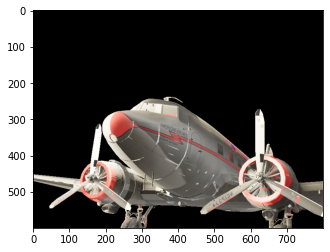

[[ 9.07935801e-01  1.20774581e-02 -4.18935217e-01  4.92619000e+00]
 [ 1.37071934e-02  9.98194252e-01  5.84837462e-02  1.91900000e-01]
 [-4.18885061e-01  5.88419130e-02 -9.06130750e-01  1.24863500e+01]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
lk point:  [ 4.50725478  0.25038375 11.58021925]
up, [0.01207746 0.99819425 0.05884191]
Scene construction, time: 0.05916 s
Forward pass, time: 0.03828 s
=== torch.Size([3, 300, 400])
torch.Size([1, 1, 300, 400])
=== torch.Size([3, 300, 400])


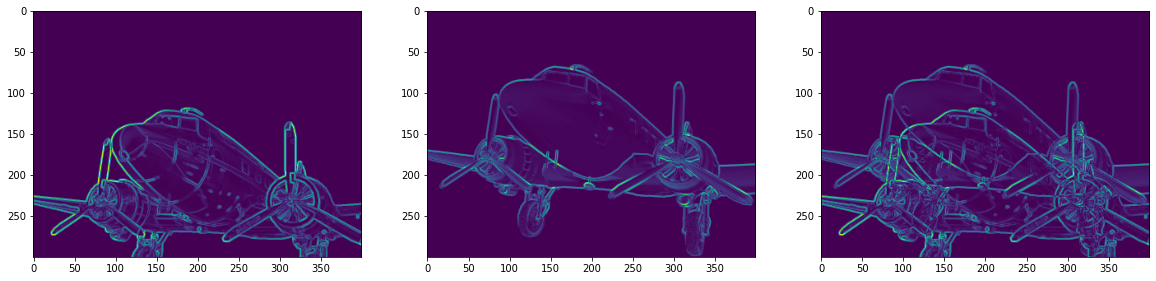

In [260]:
# nice example:  ml - (65, 21)
pose_optimization.get_tgandsource_from_sweep(65,21, 1)

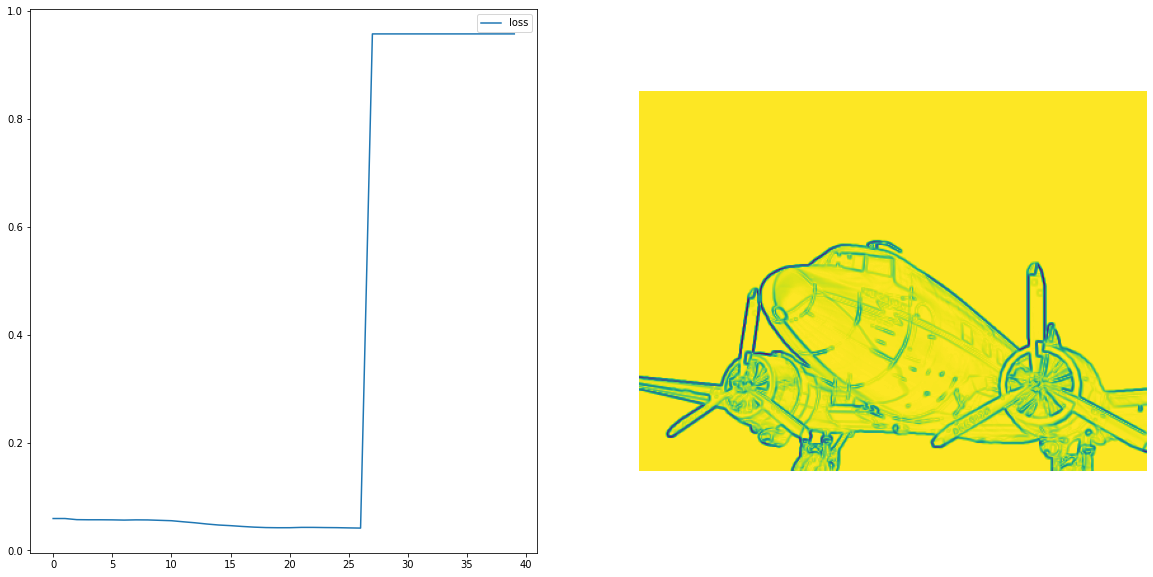

===================/content/drive/MyDrive/BigDataHub/Differentiable_Render/opt_process/edge_opt_39.jpg
cam pose==== tensor([ 4.7490, -0.0778, 12.3648], device='cuda:0', requires_grad=True)
cam lookat=== tensor([ 4.6852,  0.5214, 11.7182], device='cuda:0', requires_grad=True)
cam up=== tensor([ 0.1379,  1.0007, -0.0255], device='cuda:0', requires_grad=True)
Scene construction, time: 0.04256 s
Forward pass, time: 0.02143 s
=== torch.Size([3, 300, 400])
tensor([ 4.7490, -0.0778, 12.3648], device='cuda:0', requires_grad=True) tensor([ 4.6852,  0.5214, 11.7182], device='cuda:0', requires_grad=True)
[[ 0.63187093  0.13787681  0.06383705]
 [ 0.14649464  0.02545265 -0.64669037]
 [-0.09078842  1.00066745 -0.59919417]]
[ 4.74900723e+00 -1.23648453e+01 -7.77511448e-02  5.95210398e-01
  7.96914575e-01  1.02746860e-01 -9.73785841e-03]
dis_info ====  ['40' '0.9575362801551819' '0.3447736556083081' '0.17801280158781888'
 '0.22804105779396563' 'edge_opt_40.jpg']
recovery_p ====  [ 4.74900723e+00 -1.23

KeyboardInterrupt: ignored

In [261]:
pose_optimization.optimization_pose(100, True)

### Plot change of distance between source image and target images through over the optimization 

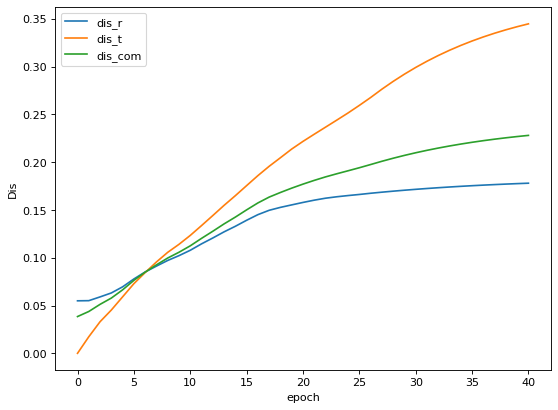

In [262]:

plot_pos_dis_change(pose_optimization.pose_dis_profile)

### Plot the top best performance 

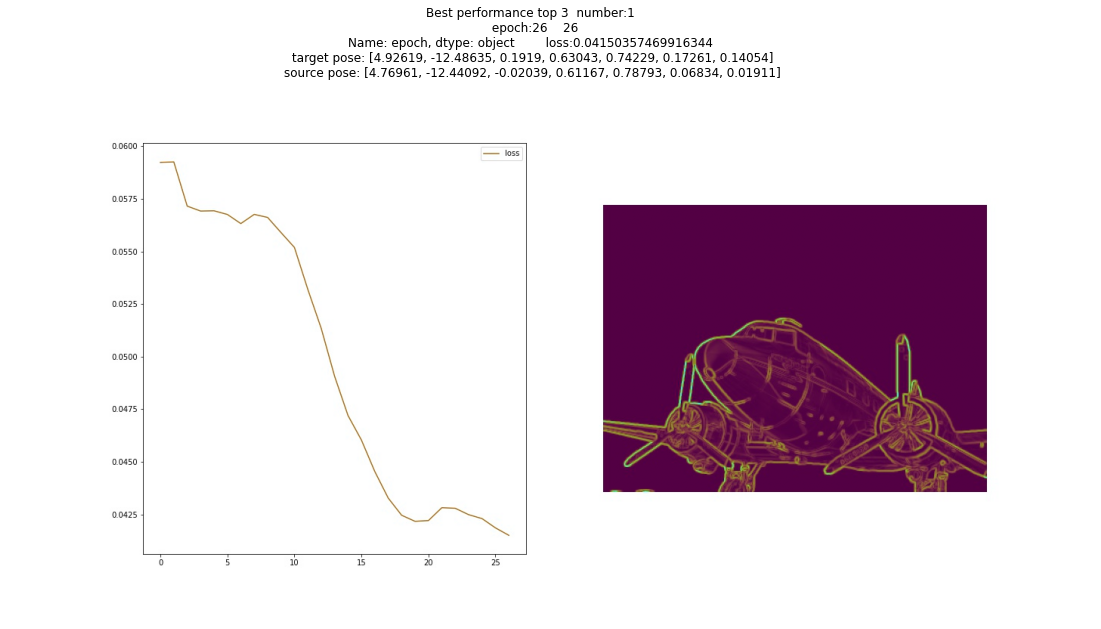

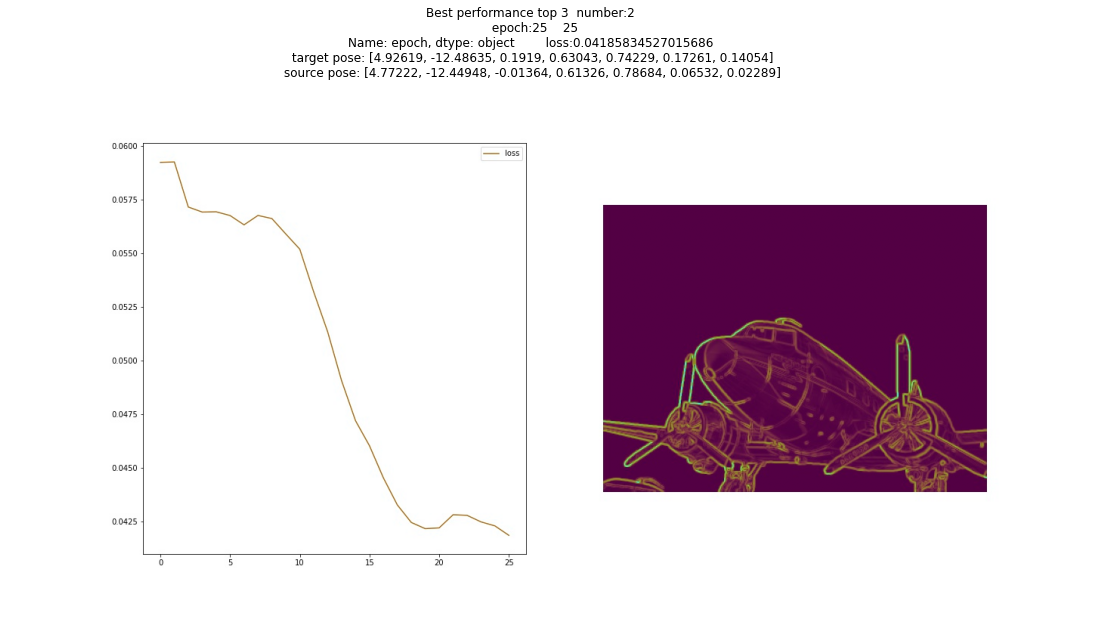

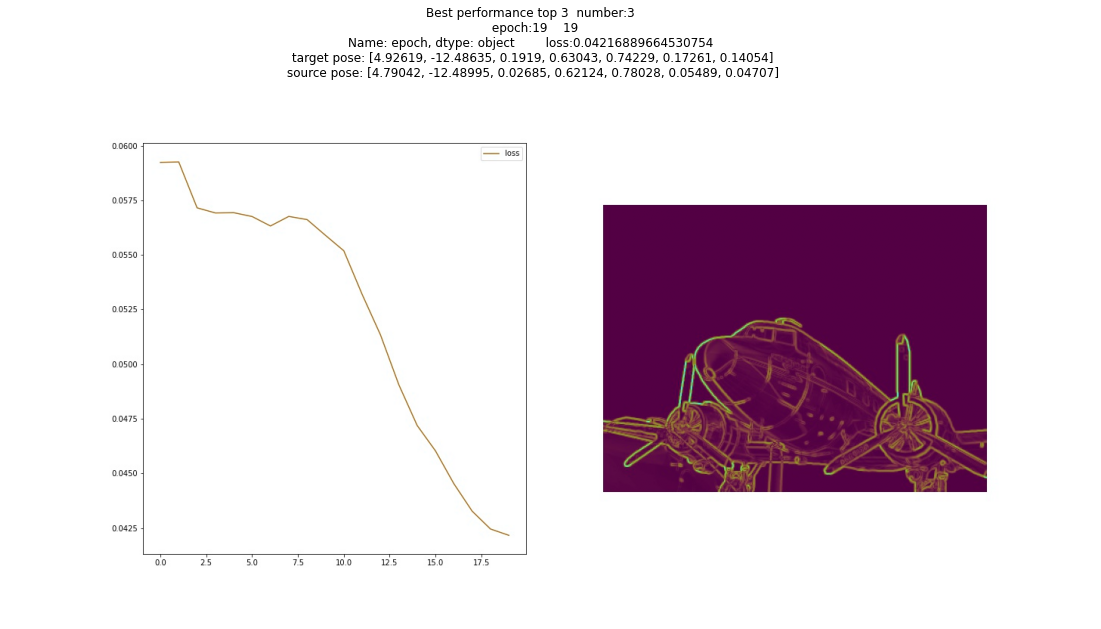

In [263]:
plot_best_performance(pose_optimization.pose_dis_profile)




### make optimization video

In [ ]:
from subprocess import call
#make video of optimization process
def make_video_by_images(save_dir, name, format, framerate):
  # framerate is type of string
    call(["ffmpeg", "-framerate", framerate, "-i",
      save_dir + "{}_%d.{}".format(name,format), "-vb", "30M",
      save_dir+ "{}.avi".format(name)])


In [ ]:
save_dir = "opt_process/"
make_video_by_images(save_dir,"edge_opt", 'jpg', "10")
make_video_by_images(save_dir,"network_opt", 'jpg', "5")

### compare result with ML and engineered
Given a sweep from training or validate data
initial source img as perbubation in sweep

comparison:
- best optimized pose by Engineered 
- best optimized pose by ML

In [ ]:
def vector_dis(pose1, pose2):
  return numpy.norm(pose1 - pose2)

In [ ]:
seq_file = "metadata_train_sequence.txt"
ex_id = 

sweep_info = get_sweep_info(seq_file, ex_id) 

tg_img_name = sweep_inf[0]
tg_pose = sweep_info[11]
s_names_list = sweep_info[1:11]
s_poses_list = sweep_info[12:22]

for idx, s_pose_img in enumerate(s_poses_list):
  # optimization process 
  best_p_eg = optimization_pose(200, cam_parameters, "1")
  best_p_ml = optimization_pose(200, cam_parameters, "2")
  
  # calculate L2 distance
  pos_dis_eg = vector_dis(tg_pose, s_pose_img)
  pos_dis_ml = vector_dis(tg_pose, best_p_ml)

  
  loginfo = [tg_img_name, s_names_list[idx], tg_pose, s_pose_img, best_p_eg, best_p_ml, pos_dis_eg, pos_dis_ml]

  


## Pick up the bad phoptoes in training data, 
where renderred images don't align with original one by using the pose vector in meta file 

In [ ]:
import pandas as pd
df_st = pd.read_csv("/content/drive/My Drive/BigDataHub/Differentiable_Render/dataset/metadata.txt",header=0)


FileNotFoundError: ignored

In [ ]:
for i in range(1,9):
  df_st[i] = None
df_st
#df_st.loc[:,10:11] = df_st.loc[:,10].str.split(expand=True).values

In [ ]:
 df_st.loc[:,0:8] = df_st.loc[:,0].str.split(expand=True).values

In [ ]:
img_id = '5'
is_seq = df_st[0].str.slice(start = 40) == 'rgb_'+ img_id + '.png'
df_st[is_seq].loc[:,1:7].to_numpy()[0].tolist()

['-6.522355',
 '-18.14907',
 '-0.7008934',
 '-0.7138588',
 '-0.6739503',
 '-0.1029228',
 '0.1600116']

In [ ]:


#read images from metadata file 
for img_id in range(20,41):
    synthetic_base_dir = '/content/drive/MyDrive/BigDataHub/Differentiable_Render/dataset/'

    img_name = str(img_id).zfill(5) + '.jpg'
    seg_name = str(img_id).zfill(5) +'.png'

    with_resize = False
    img_size=  (289, 513)  

    # target image rgb version with segmentation
    target_img = gen_target(synthetic_base_dir, img_name, seg_name)

    #render image by vector
    is_pose = df_st[0].str.slice(start = 40) == 'rgb_'+ str(img_id) + '.png'
    pose = df_st[is_pose].loc[:,1:7].to_numpy()[0].tolist()
    pose = list(map(lambda x:float(x), pose))
    print("target pose", pose)

    cam_pose, lookat, up, lookat_mat = initial_pose_from_quaternion(pose)
    img = model_cam(cam_pose, lookat, up, resolution=img_size) 
    init_normal = img[:, :, 1:4]    
    diff_img = np.abs(init_normal.cpu().data.numpy()*255 - target_img)

    file_name = "diff_" + str(img_id) +".jpg"
    path = os.path.join("/content/drive/MyDrive/BigDataHub/Differentiable_Render/dataset/diff", file_name)
    print(path)
    print(diff_img.shape)
    cv2.imwrite(path, diff_img)


target pose [8.217258, -9.033538, -1.146944, -0.6689304, -0.6307245, -0.3046483, -0.2488139]
[[ 0.69056207  0.05142012 -0.72144306  8.217258  ]
 [-0.09371097  0.99542284 -0.01875198 -1.146944  ]
 [-0.71717668 -0.08055653 -0.69221991  9.033538  ]
 [ 0.          0.          0.          1.        ]]
lk point: [ 6.77437189 -1.18444796  7.64909817]
Scene construction, time: 0.04057 s
Forward pass, time: 0.02968 s
/content/drive/MyDrive/BigDataHub/Differentiable_Render/dataset/diff/diff_20.jpg
(289, 513, 3)
target pose [-12.79831, 13.07425, -0.8140812, -0.2593946, -0.3109394, 0.638509, 0.654475]
[[-6.72062457e-01 -5.75407669e-02  7.38255501e-01 -1.27983100e+01]
 [-7.57525563e-02  9.97088194e-01  8.75411183e-03 -8.14081200e-01]
 [ 7.36609578e-01  5.00414297e-02  6.74464405e-01 -1.30742500e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
lk point: [-11.321799    -0.79657298 -11.72532119]
Scene construction, time: 0.04331 s
Forward pass, time: 0.02626 s
/content/drive/My

In [ ]:
for i in range(0):
  print (i)